# Sample of infinite size in both x and y directions  

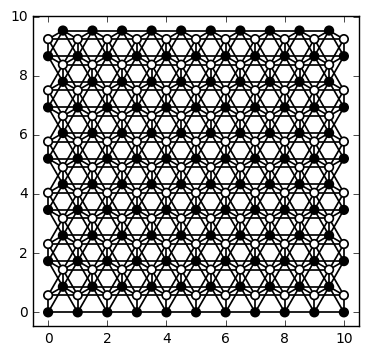

In [1]:
import matplotlib.pyplot
from math import sqrt, pi
import kwant
#There is a built-in "honeycomb" lattice in KWANT, but here the lattice is introduced by hand
sin_30, cos_30 = (1 / 2, sqrt(3) / 2)
lat2D = kwant.lattice.general([(1, 0), (sin_30, cos_30)],
                                 [(0, 0), (0, 1 / sqrt(3))])
aSub, bSub = lat2D.sublattices

sys2D = kwant.Builder()


SitesCount_X = 10
SitesCount_Y = 10

def IfBulkSite( position):
    x, y = position
    return (x - SitesCount_X/2)**2 <= (SitesCount_X/2)**2 and (y - SitesCount_Y/2)**2 <= (SitesCount_Y/2)**2

sys2D[lat2D.shape(IfBulkSite, (0,0))] = 0

HoppingConstantNN = 1.
hoppingsNN = (((0, 0), aSub, bSub), ((0,1), aSub, bSub), ((-1,1), aSub, bSub))

HoppingConstantNNN = 0.2
hoppingsNNN = (((0,1), aSub, aSub), ((1,0), aSub, aSub), ((1,-1), aSub, aSub), \
              ((0,1), bSub, bSub), ((1,0), bSub, bSub), ((1,-1), bSub, bSub))

sys2D[[kwant.builder.HoppingKind(*hopping) for hopping in hoppingsNN]] = - HoppingConstantNN
sys2D[[kwant.builder.HoppingKind(*hopping) for hopping in hoppingsNNN]] = - HoppingConstantNNN

def family_colors(site):
    return 0 if site.family == aSub else 1
    
kwant.plot(sys2D, site_color=family_colors, site_lw=0.1, colorbar=False)

fsys2D = sys2D.finalized()

In [2]:
ham_sparse_coo = fsys2D.hamiltonian_submatrix( sparse=True )
ham_sparse = ham_sparse_coo.tocsc()

EigenvectorsCount = 50

from scipy.sparse import linalg as lag
import numpy as np
EigenValues, EigenVectors = lag.eigsh( ham_sparse,k=EigenvectorsCount,which='LM',sigma=0, tol=10**(-3) )

EigenVectors = np.transpose(EigenVectors)
#Sorting the wavefunctions by eigenvalues, so that the states with the lowest energies come first
idx = EigenValues.argsort()
EigenValues = EigenValues[idx]
EigenVectors = EigenVectors[idx]

[energy for energy in EigenValues if energy < 0.01 and energy > -0.01]

[-0.0014635881532258461]

## Note that below I do not actually use the KWANT calculations, only pure analytics of the tight-binding model

In [3]:
from tinyarray import array as ta
import numpy
from numpy import exp, linalg, sqrt, cos

def EigenEnergiesNN(pxArray, pyArray, EnergyBand, tNN = 1., tNNN = 0.):
    EigenEnergiesArray = []
    i = -1
    for px in pxArray:
        EigenEnergiesArray.append([])
        i = i+1
        for py in pyArray:
            Ham12 = tNN * ( exp(1j*py) + 2.*cos(sqrt(3.)*px/2.)*exp(-1j*py/2.) )
            HamDiag = tNNN * 2. * (cos(sqrt(3.)*px) + 2.*cos(sqrt(3.)*px/2.)*cos(3.*py/2.))
            EffectiveHamiltonianNN = numpy.matrix([[HamDiag, Ham12], [numpy.conj(Ham12), HamDiag]])
            EnergySpectrum = linalg.eigvalsh(EffectiveHamiltonianNN)
            EigenEnergiesArray[i].append(EnergySpectrum[EnergyBand])
            
    return EigenEnergiesArray

## Inclusion of only the nearest-neighbour couplings

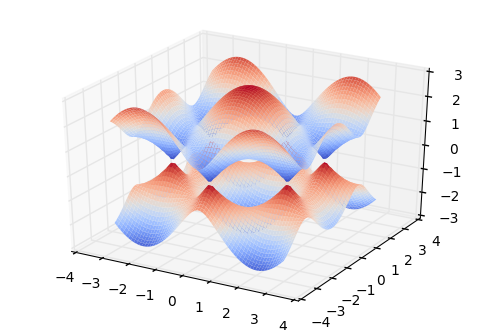

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-pi, pi, 0.1)
Y = np.arange(-pi, pi, 0.1)
pX, pY = np.meshgrid(X, Y)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,0), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,1), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

plt.show()
del fig, ax, X, Y, pX, pY

## One of the Dirac points is at $p^x = \frac{4\pi}{3\sqrt{3} a_\text{NN}}$, $p^y = 0$ 

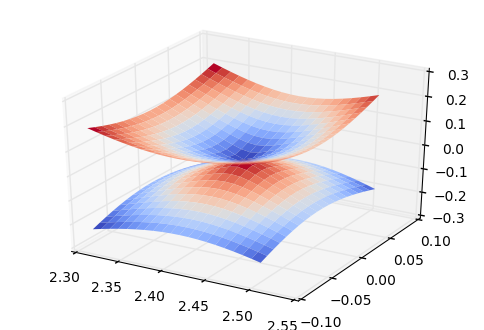

In [5]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(4*pi/3/sqrt(3) - 0.1, 4*pi/3/sqrt(3) + 0.1, 0.0101)
Y = np.arange(-0.1, 0.1, 0.01)
pX, pY = np.meshgrid(X, Y)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,0), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,1), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

plt.show()

del fig, ax, X, Y, pX, pY

## NNN couplings: the energy spectrum is not symmetric wrt zero energy, but the Dirac cones are still present 

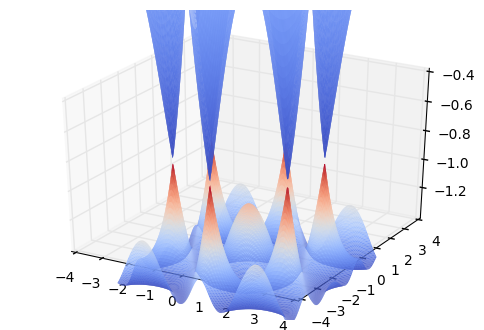

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-pi, pi, 0.03)
Y = np.arange(-pi, pi, 0.03)
pX, pY = np.meshgrid(X, Y)
tNN = 1.
tNNN = 0.3

ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,0,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,1,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.set_zlim(-3.*tNNN-0.5, -3.*tNNN+0.5)

plt.show()

del fig, ax, X, Y, pX, pY, tNN, tNNN

The energy of a Dirac node is [[-0.90000000000000036]] while the expected value is -0.8999999999999999


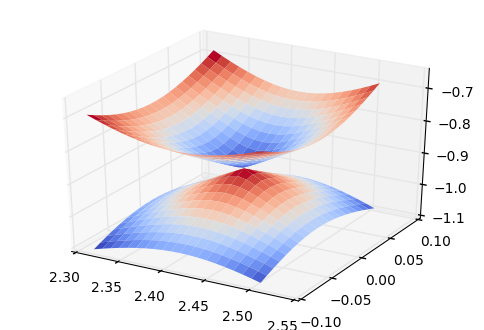

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(4*pi/3/sqrt(3) - 0.1, 4*pi/3/sqrt(3) + 0.1, 0.0101)
Y = np.arange(-0.1, 0.1, 0.01)
pX, pY = np.meshgrid(X, Y)
tNN = 1.
tNNN = 0.3
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,0,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,1,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)

print('The energy of a Dirac node is',EigenEnergiesNN([4*pi/3/sqrt(3)],[0],0,tNN=tNN,tNNN=tNNN), \
      'while the expected value is',-3.*tNNN)

plt.show()

del fig, ax, X, Y, pX, pY, tNN, tNNN

## However, if we further increase the NNN hopping, other states at the energy of the Dirac nodes will appear

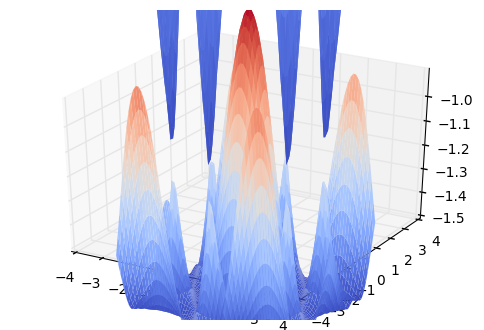

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(-pi, pi, 0.1)
Y = np.arange(-pi, pi, 0.1)
pX, pY = np.meshgrid(X, Y)
tNN = 1.
tNNN = 0.4

ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,0,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.plot_surface(pX, pY, EigenEnergiesNN(X,Y,1,tNN=tNN,tNNN=tNNN), rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.set_zlim(-3.*tNNN-0.3, -3.*tNNN+0.3)

plt.show()

del fig, ax, X, Y, pX, pY, tNN, tNNN